In [1]:
import os
import sys
# from Bio import SeqIO
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# import xgboost as xgb
# from sklearn.svm import SVC

import math

from lncRNAmiRNA import DForest

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
##################################################################################
##### Define all experiment parameters
##################################################################################

expName = "MathFeature_setting1"
outPath = "Generated"

dataset_path = "Datasets"
setting = "Setting1"
output_path = "Results_ALL_cosineSimilarityAE_DeepForest"

datafile_extensions = ".csv"

modelNames = ["DeepForest"]

shuffle = True
seed = 123

reject_encoding_list = ["ALL", "NM-complex", "kmer", "kstep", "rckmer"]

epochs = 100
batch_size = 64

##################################################################################
##### Define the modelling hyperparameters
##################################################################################

n_fold = 5


In [4]:
##################################################################################
##### Checking the directory
##################################################################################

dataset_setting_path = os.path.join(outPath, expName, dataset_path, setting)
dataset_varieties = next(os.walk(dataset_setting_path))
result_output_path = os.path.join(outPath, expName, output_path, setting)

In [5]:
##################################################################################
##### define evaluator functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

def pred2label(y_pred):
    y_pred = np.round(np.clip(y_pred, 0, 1))
    return y_pred

In [6]:
def autoEncoder_1D(input_length,
                   latent_space_size = 500,
                   learn_rate = 0.001, 
                   loss = 'mean_squared_error', 
                   metrics = None):

    """
    Simple Autoencoder, full connected network.
    """
    
    inputs = tf.keras.Input(shape = input_length)
    
    # encoded = Dense(units = latent_space_size*2, activation='relu')(inputs)
    
    # encoder = tf.keras.layers.Dense(units = latent_space_size)(inputs)
    # decoder = tf.keras.layers.Dense(units = input_length)(encoder)
    
    enc1 = tf.keras.layers.Dense(units = int(input_length/2))(inputs)
    encoder = tf.keras.layers.Dense(units = latent_space_size)(enc1)
    dec1 = tf.keras.layers.Dense(units = int(input_length/2))(encoder)
    decoder = tf.keras.layers.Dense(units = input_length)(dec1)
    
    # encoded = Dense(encoding_dim, activation='relu')(input_img)
    # decoded = Dense(328, activation='sigmoid')(encoded)
    
    encoder = tf.keras.Model(inputs, encoder)
    autoencoder = tf.keras.Model(inputs, decoder)
    
    # autoencoder.compile(optimizer = tf.keras.optimizers.Adam(lr = learn_rate), loss = loss)
    # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    autoencoder.compile(optimizer = tf.keras.optimizers.Adadelta(lr = learn_rate), loss = loss)
    
    return autoencoder, encoder

## Data generation by joining from all encodings

In [7]:
# for dataset_variety in dataset_varieties[1]:
#     current_dataset_variety_path = os.path.join(dataset_setting_path, dataset_variety)
    
    
#     print("\nProcessing variety: ", dataset_variety)
#     print("======================================")
    
#     i = 0
    
#     for root, dirs, files in os.walk(current_dataset_variety_path):
#         for file in files:
#             if os.path.splitext(file)[-1] == datafile_extensions:
                
#                 encoding_type = file.split(".")[0].split("_")[-1]
                
#                 if encoding_type not in reject_encoding_list:
                
#                     input_file_full_path = os.path.join(root, file)

#                     ## check if input file has header
#                     file_obj = open(input_file_full_path, "r")
#                     first_line = file_obj.readline()
#                     file_obj.close()
#                     file_has_header = None
#                     if first_line.split(",")[0] == "nameseq" or first_line.replace("\n", "").split(",")[-1] == "label":
#                         file_has_header = 0

#                     sequences_df = pd.read_csv(input_file_full_path, header = file_has_header)
                    
#                     ## adding encoding type to header names
#                     cols = list(sequences_df.columns)
#                     cols = [encoding_type+"_"+str(col) for col in cols]
#                     sequences_df.columns = cols
                    
#                     # sequences_df = pd.read_csv(input_file_full_path, header = "infer")
#                     # print("Encoding completed adding: ", encoding_type)
#                     # print("Columns: ", sequences_df.columns)
                    
#                     sequences_df = sequences_df.rename(columns = {sequences_df.columns[0] : 'nameseq', 
#                                                                   sequences_df.columns[-1] : 'label'})
                    
#                     sequences_df = sequences_df.drop("label", axis = 1)
                    
#                     if i == 0:
#                         variety_dataset_df = sequences_df
                        
#                     else:
#                         # variety_dataset_df = pd.concat([variety_dataset_df, sequences_df], 
#                         #                                join="inner", 
#                         #                                keys = ("nameseq"), 
#                         #                                ignore_index = True, 
#                         #                                axis = 1)
#                         # variety_dataset_df = variety_dataset_df.rename(columns = {0 : 'nameseq'})
                        
#                         variety_dataset_df = pd.merge(variety_dataset_df, sequences_df, 
#                                                       left_on='nameseq', right_on='nameseq', 
#                                                       how='inner')
                    
#                     print("Encoding completed adding: ", encoding_type)
                    
#                     i = i+1
                    
#     file_name = "_".join(file.split(".")[0].split("_")[0:-1]+["ALL"])+"."+file.split(".")[1]
#     variety_dataset_df.to_csv(os.path.join(root, file_name), 
#                               header = True, 
#                               index = False)
    
#     print("======================================")

### Nan/Infinity correction - dropping columns

In [8]:
# for root, dirs, files in os.walk(dataset_setting_path):
#     for file in files:
#         if (os.path.splitext(file)[-1] == datafile_extensions) & (file.split(".")[0].split("_")[-1] == "ALL"):
            
#             input_file_full_path = os.path.join(root, file)
            
#             print(" Processing file : ",input_file_full_path)
            
#             sequences_df = pd.read_csv(input_file_full_path, header = "infer", low_memory=False)
            
#             vals = sequences_df.drop("nameseq", axis = 1).values.astype(np.float)
#             sequences_df_columns = sequences_df.drop("nameseq", axis = 1).columns

#             if np.isnan(np.max(vals)):
#                 nans = np.argwhere(np.isnan(vals.astype(np.float)))
#                 vals = np.delete(vals, np.unique(nans[:,1]), axis=1)
#                 drop_cols = sequences_df_columns[np.unique(nans[:,1])]
#                 for drop_col in drop_cols:
#                     sequences_df = sequences_df.drop(drop_col, axis = 1)

#             sequences_df_columns = sequences_df.drop("nameseq", axis = 1).columns

#             if np.max(vals)>1e+308:
#                 vals = np.where(vals == np.max(vals), 
#                                 None, 
#                                 vals)
#                 nans = np.argwhere(np.isnan(vals.astype(np.float)))
#                 vals = np.delete(vals, np.unique(nans[:,1]), axis=1)
#                 drop_cols = sequences_df_columns[np.unique(nans[:,1])]
#                 for drop_col in drop_cols:
#                     sequences_df = sequences_df.drop(drop_col, axis = 1)
                    
#             sequences_df.to_csv(input_file_full_path.replace("_ALL", "_ALL-v2"), 
#                                 header = True, 
#                                 index = False)
            
#             print(" Generated file : ",input_file_full_path.replace("_ALL", "_ALL-v2"))
#             print("\n################################################\n")

## Modelling

In [9]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

error_list = []

## create the evaluation data structure for all iterations
evaluations = {
    "Model" : [],
    "Encoding_Type" : [],
    "Dataset" : [],
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

for root, dirs, files in os.walk(dataset_setting_path):
    for file in files:
        if (os.path.splitext(file)[-1] == datafile_extensions) & (file.split(".")[0].split("_")[-1] == "ALL-v2"):
            
#             try:
            
            current_dataset_variety = root.split("\\")[len(root.split("\\"))-1]
            encoding_type = file.split(".")[0].split("_")[-1]

            ##################################################################################
            ##### read the current file
            ##################################################################################

            input_file_full_path = os.path.join(root, file)
            sequences_df = pd.read_csv(input_file_full_path, header = "infer", low_memory=False)

            ##################################################################################
            ##### extract data from the current dataframe file
            ##################################################################################

            sequences_df["class"] = np.where(sequences_df[sequences_df.columns[0]].str.contains("nucleosomal"), 1, 0)

            print("\n======================================================================")
            print("\nFile: "+os.path.join(root, file))
            print("Nucleosomi: "+str(sum(sequences_df["class"])))
            print("Linker: "+str(len(sequences_df) - sum(sequences_df["class"])))
            
            ##################################################################################
            ##### Extract Feature/Label vectors
            ##################################################################################
            
            ## create the features and labels datasets for the training
            labels = np.array(sequences_df["class"])
            features = sequences_df.drop("nameseq", axis = 1).drop("class", axis = 1).values
            # features = features.reshape(features.shape + (1,))
            
            x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2)
            
            ##################################################################################
            ##### Encoding the MathFeature vectors using a simple AutoEncoder model
            ##################################################################################
            
            ## Create and set directory to save model
            ae_modelPath = os.path.join(result_output_path, current_dataset_variety, 
                                        "{}fold".format(n_fold), 
                                        "models", "AutoEncoder")
            if(not os.path.isdir(ae_modelPath)):
                os.makedirs(ae_modelPath)
                
            ## Generate model object
            ae_model, encoder = autoEncoder_1D(input_length = features.shape[1], 
                                               learn_rate = 0.1, 
                                               loss = "cosine_similarity")
            ## Define model training callbacks
#             modelCallbacks = [
#                 tf.keras.callbacks.ModelCheckpoint(os.path.join(ae_modelPath, "{}_bestModel.hdf5".format("AutoEncoder")),
#                                                    monitor = 'val_loss', verbose = 0, save_best_only = True, 
#                                                    save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
#                 tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, 
#                                                  mode = 'auto', baseline = None, restore_best_weights = False)
#             ]
            modelCallbacks = [
                tf.keras.callbacks.ModelCheckpoint(os.path.join(ae_modelPath, "{}_bestModel.hdf5".format("AutoEncoder")),
                                                   monitor = 'val_loss', verbose = 0, save_best_only = True, 
                                                   save_weights_only = False, mode = 'auto', save_freq = 'epoch')
            ]
            ## Train the AutoEncoder
            ae_model.fit(x = x_train, 
                         y = x_train, 
                         batch_size = batch_size, epochs = epochs, verbose = 1, callbacks = modelCallbacks, 
                         validation_data = (x_valid, x_valid))
            
            ## Generate Latent-Space representation for the entire feature set
            features_encoded = encoder.predict(features)
            
            ##################################################################################
            ##### Generate Folds from dataset, and store to file
            ##################################################################################
            
            ## Parameters to Read/Write the k-fold dataset to file
            foldPath = os.path.join(result_output_path, current_dataset_variety, "{}fold".format(n_fold))
            foldName = file.split(".")[0]+"_{}fold".format(n_fold)+".pickle"

            ##### ADDITIONAL CHANGES - USE PREVIOUS GENERATED FOLDS IF AVAILABLE

            if(os.path.isfile(os.path.join(foldPath, foldName))):
                folds = pickle.load(open(os.path.join(foldPath, foldName), "rb"))
            else:
                ## Generate the k-fold dataset
                # folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)
                folds = build_kfold(features_encoded, labels, k=n_fold, shuffle=shuffle, seed=seed)
                if(not os.path.isdir(foldPath)):
                    os.makedirs(foldPath)
                pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))
            
            ##################################################################################
            ##### Run Models for all folds
            ##################################################################################
            
            for modelName in modelNames:

                ## Create and set directory to save model
                modelPath = os.path.join(result_output_path, current_dataset_variety, "{}fold".format(n_fold), "models", modelName)
                if(not os.path.isdir(modelPath)):
                    os.makedirs(modelPath)

                ## fold counter
                i = 0

                for fold in folds:

                    print("\nTrain/Test model "+modelName+" on Fold #"+str(i)+".")
                    
                    model = DForest(shape_1X=fold["X_train"].shape[1], n_mgsRFtree=200, window=[20, 40], stride=2,
                                    cascade_test_size=0.2, n_cascadeRF=2, n_cascadeRFtree=200, cascade_layer=np.inf,
                                    min_samples_mgs=0.00001, min_samples_cascade=0.0005, tolerance=0.0, n_jobs=-1)
                    
                    model.fit(X = fold["X_train"], 
                              y = fold["y_train"])
                    
                    model_filename = "{}_fold{}_model.pickle".format(modelName, i)
                    model_file_obj = open(os.path.join(modelPath, model_filename), 'wb')
                    pickle.dump(model, model_file_obj)
                    model_file_obj.close()
                    
                    ##################################################################################
                    ##### Prediction and metrics for TRAIN dataset
                    ##################################################################################

                    y_pred = model.predict(fold["X_train"])
                    label_pred = pred2label(y_pred)
                    
                    # Compute precision, recall, sensitivity, specifity, mcc
                    acc = accuracy_score(fold["y_train"], label_pred)
                    prec = precision_score(fold["y_train"],label_pred)

                    conf = confusion_matrix(fold["y_train"], label_pred)
                    if(conf[0][0]+conf[1][0]):
                        sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                    else:
                        sens = 0.0
                    if(conf[1][1]+conf[0][1]):
                        spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                    else:
                        spec = 0.0
                    if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                        mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                    else:
                        mcc= 0.0
                    fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
                    auc = roc_auc_score(fold["y_train"], y_pred)

                    evaluations["Model"].append(modelName)
                    evaluations["Encoding_Type"].append(encoding_type)
                    evaluations["Dataset"].append(current_dataset_variety)
                    evaluations["Fold"].append(i)
                    evaluations["Train_Test"].append("Train")
                    evaluations["Accuracy"].append(acc)
                    evaluations["Precision"].append(prec)
                    evaluations["TPR"].append(tpr)
                    evaluations["FPR"].append(fpr)
                    evaluations["TPR_FPR_Thresholds"].append(thresholds)
                    evaluations["AUC"].append(auc)
                    evaluations["Sensitivity"].append(sens)
                    evaluations["Specificity"].append(spec)
                    evaluations["MCC"].append(mcc)

                    ##################################################################################
                    ##### Prediction and metrics for TEST dataset
                    ##################################################################################

                    y_pred = model.predict(fold["X_test"])
                    label_pred = pred2label(y_pred)
                    
                    # Compute precision, recall, sensitivity, specifity, mcc
                    acc = accuracy_score(fold["y_test"], label_pred)
                    prec = precision_score(fold["y_test"],label_pred)

                    conf = confusion_matrix(fold["y_test"], label_pred)
                    if(conf[0][0]+conf[1][0]):
                        sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                    else:
                        sens = 0.0
                    if(conf[1][1]+conf[0][1]):
                        spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                    else:
                        spec = 0.0
                    if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                        mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                    else:
                        mcc= 0.0
                    fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
                    auc = roc_auc_score(fold["y_test"], y_pred)

                    evaluations["Model"].append(modelName)
                    evaluations["Encoding_Type"].append(encoding_type)
                    evaluations["Dataset"].append(current_dataset_variety)
                    evaluations["Fold"].append(i)
                    evaluations["Train_Test"].append("Test")
                    evaluations["Accuracy"].append(acc)
                    evaluations["Precision"].append(prec)
                    evaluations["TPR"].append(tpr)
                    evaluations["FPR"].append(fpr)
                    evaluations["TPR_FPR_Thresholds"].append(thresholds)
                    evaluations["AUC"].append(auc)
                    evaluations["Sensitivity"].append(sens)
                    evaluations["Specificity"].append(spec)
                    evaluations["MCC"].append(mcc)

                    i = i+1
                        
#             except Exception as error:
#                 error_list.append((input_file_full_path, error))
                
##################################################################################
##### Dump evaluations to a file
##################################################################################

evalPath = os.path.join(result_output_path, "_Evaluation_All_Datasets", "{}fold".format(n_fold))
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

pickle.dump(evaluations,
            open(os.path.join(evalPath, "{}fold_evaluations_{}.pickle".format(n_fold, modelNames[0])), "wb"))

##################################################################################
##### Dump exceptions to a file
##################################################################################

pickle.dump(error_list,
            open(os.path.join(result_output_path, "exceptions.pickle"), "wb"))




File: Generated\MathFeature_setting1\Datasets\Setting1\Drosophila\nucleosomes_vs_linkers_melanogaster_ALL-v2.csv
Nucleosomi: 2900
Linker: 2850
Epoch 1/100
72/72 [==============================] - 1s 13ms/step - loss: -0.8383 - val_loss: -0.9918
Epoch 2/100
72/72 [==============================] - 1s 9ms/step - loss: -0.9935 - val_loss: -0.9929
Epoch 3/100
72/72 [==============================] - 1s 9ms/step - loss: -0.9938 - val_loss: -0.9941
Epoch 4/100
72/72 [==============================] - 1s 9ms/step - loss: -0.9947 - val_loss: -0.9944
Epoch 5/100
72/72 [==============================] - 1s 8ms/step - loss: -0.9948 - val_loss: -0.9945
Epoch 6/100
72/72 [==============================] - 1s 8ms/step - loss: -0.9951 - val_loss: -0.9948
Epoch 7/100
72/72 [==============================] - 1s 9ms/step - loss: -0.9954 - val_loss: -0.9952
Epoch 8/100
72/72 [==============================] - 1s 8ms/step - loss: -0.9957 - val_loss: -0.9955
Epoch 9/100
72/72 [===========================

72/72 [==============================] - 0s 6ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 80/100
72/72 [==============================] - 0s 6ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 81/100
72/72 [==============================] - 0s 6ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 82/100
72/72 [==============================] - 0s 6ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 83/100
72/72 [==============================] - 1s 8ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 84/100
72/72 [==============================] - 0s 6ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 85/100
72/72 [==============================] - 0s 6ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 86/100
72/72 [==============================] - 0s 6ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 87/100
72/72 [==============================] - 0s 6ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 88/100
72/72 [==============================] - 0s 6ms/step - loss: -1.0000 - val_loss: -

65/65 [==============================] - 1s 9ms/step - loss: -0.9995 - val_loss: -0.9995
Epoch 42/100
65/65 [==============================] - 1s 9ms/step - loss: -0.9996 - val_loss: -0.9995
Epoch 43/100
65/65 [==============================] - 1s 9ms/step - loss: -0.9996 - val_loss: -0.9995
Epoch 44/100
65/65 [==============================] - 1s 9ms/step - loss: -0.9996 - val_loss: -0.9996
Epoch 45/100
65/65 [==============================] - 1s 9ms/step - loss: -0.9997 - val_loss: -0.9996
Epoch 46/100
65/65 [==============================] - 1s 9ms/step - loss: -0.9997 - val_loss: -0.9996
Epoch 47/100
65/65 [==============================] - 1s 9ms/step - loss: -0.9997 - val_loss: -0.9997
Epoch 48/100
65/65 [==============================] - 1s 9ms/step - loss: -0.9997 - val_loss: -0.9997
Epoch 49/100
65/65 [==============================] - 1s 9ms/step - loss: -0.9997 - val_loss: -0.9997
Epoch 50/100
65/65 [==============================] - 1s 9ms/step - loss: -0.9998 - val_loss: -

Epoch 5/100
58/58 [==============================] - 1s 9ms/step - loss: -0.9958 - val_loss: -0.9964
Epoch 6/100
58/58 [==============================] - 1s 9ms/step - loss: -0.9960 - val_loss: -0.9966
Epoch 7/100
58/58 [==============================] - 1s 9ms/step - loss: -0.9962 - val_loss: -0.9966
Epoch 8/100
58/58 [==============================] - 1s 9ms/step - loss: -0.9962 - val_loss: -0.9968
Epoch 9/100
58/58 [==============================] - 1s 9ms/step - loss: -0.9964 - val_loss: -0.9968
Epoch 10/100
58/58 [==============================] - 1s 9ms/step - loss: -0.9965 - val_loss: -0.9971
Epoch 11/100
58/58 [==============================] - 1s 9ms/step - loss: -0.9968 - val_loss: -0.9972
Epoch 12/100
58/58 [==============================] - 1s 9ms/step - loss: -0.9968 - val_loss: -0.9973
Epoch 13/100
58/58 [==============================] - 1s 9ms/step - loss: -0.9970 - val_loss: -0.9974
Epoch 14/100
58/58 [==============================] - 1s 10ms/step - loss: -0.9971 - va

58/58 [==============================] - 1s 11ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 86/100
58/58 [==============================] - 1s 9ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 87/100
58/58 [==============================] - 1s 9ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 88/100
58/58 [==============================] - 1s 9ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 89/100
58/58 [==============================] - 1s 10ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 90/100
58/58 [==============================] - 1s 9ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 91/100
58/58 [==============================] - 1s 9ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 92/100
58/58 [==============================] - 1s 9ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 93/100
58/58 [==============================] - 1s 9ms/step - loss: -1.0000 - val_loss: -1.0000
Epoch 94/100
58/58 [==============================] - 1s 9ms/step - loss: -1.0000 - val_loss:

46/46 [==============================] - 0s 6ms/step - loss: -0.9999 - val_loss: -0.9999
Epoch 47/100
46/46 [==============================] - 0s 6ms/step - loss: -0.9999 - val_loss: -0.9999
Epoch 48/100
46/46 [==============================] - 0s 6ms/step - loss: -0.9999 - val_loss: -0.9999
Epoch 49/100
46/46 [==============================] - 0s 6ms/step - loss: -0.9999 - val_loss: -0.9999
Epoch 50/100
46/46 [==============================] - 0s 6ms/step - loss: -0.9999 - val_loss: -0.9999
Epoch 51/100
46/46 [==============================] - 0s 6ms/step - loss: -0.9999 - val_loss: -0.9999
Epoch 52/100
46/46 [==============================] - 0s 10ms/step - loss: -0.9999 - val_loss: -0.9999
Epoch 53/100
46/46 [==============================] - 0s 10ms/step - loss: -0.9999 - val_loss: -0.9999
Epoch 54/100
46/46 [==============================] - 0s 10ms/step - loss: -0.9999 - val_loss: -0.9999
Epoch 55/100
46/46 [==============================] - 0s 11ms/step - loss: -0.9999 - val_los

In [10]:
error_list

[]

## Visualization of Evaluation

In [11]:
##################################################################################
##### Add import statement here, to make this next part of code standalone executable
##################################################################################

import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import numpy as np
import pandas as pd


In [12]:
# ##################################################################################
# ##### Parameters used only in this section
# ##################################################################################

# n_fold = 10

# expName = "MathFeature_setting1_kgap_fickett"
# outPath = "Generated"
# setting = "Setting1"
# output_path = "Results"

# modelNames = ["RandomForest"]

In [13]:
##################################################################################
##### Load file and convert to dataframe for easy manipulation
##################################################################################

evalPath = os.path.join(outPath, expName, output_path, setting, "_Evaluation_All_Datasets", "{}fold".format(n_fold))

evaluations = pickle.load(open(os.path.join(evalPath, "{}fold_evaluations_{}.pickle".format(n_fold, modelNames[0])), "rb"))

evaluations_df = pd.DataFrame.from_dict(evaluations)

In [14]:
evaluations_df

,Model,Encoding_Type,Dataset,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,DeepForest,ALL-v2,Drosophila,0,Train,0.793043,0.841317,"[0.0, 0.7267241379310345, 1.0]","[0.0, 0.1394736842105263, 1.0]","[2, 1, 0]",0.793625,0.755778,0.841317,0.592153
1,DeepForest,ALL-v2,Drosophila,0,Test,0.632174,0.666667,"[0.0, 0.5413793103448276, 1.0]","[0.0, 0.2754385964912281, 1.0]","[2, 1, 0]",0.632970,0.608247,0.666667,0.270390
2,DeepForest,ALL-v2,Drosophila,1,Train,0.758043,0.820840,"[0.0, 0.6655172413793103, 1.0]","[0.0, 0.14780701754385964, 1.0]","[2, 1, 0]",0.758855,0.714601,0.820840,0.526501
3,DeepForest,ALL-v2,Drosophila,1,Test,0.654783,0.700219,"[0.0, 0.5517241379310345, 1.0]","[0.0, 0.24035087719298245, 1.0]","[2, 1, 0]",0.655687,0.624820,0.700219,0.318132
4,DeepForest,ALL-v2,Drosophila,2,Train,0.761304,0.787124,"[0.0, 0.7219827586206896, 1.0]","[0.0, 0.1986842105263158, 1.0]","[2, 1, 0]",0.761649,0.739078,0.787124,0.524748
5,DeepForest,ALL-v2,Drosophila,2,Test,0.648696,0.670543,"[0.0, 0.596551724137931, 1.0]","[0.0, 0.2982456140350877, 1.0]","[2, 1, 0]",0.649153,0.630915,0.670543,0.299878
6,DeepForest,ALL-v2,Drosophila,3,Train,0.742174,0.801917,"[0.0, 0.6491379310344828, 1.0]","[0.0, 0.1631578947368421, 1.0]","[2, 1, 0]",0.742990,0.700955,0.801917,0.494354
7,DeepForest,ALL-v2,Drosophila,3,Test,0.632174,0.667377,"[0.0, 0.5396551724137931, 1.0]","[0.0, 0.2736842105263158, 1.0]","[2, 1, 0]",0.632985,0.607930,0.667377,0.270599
8,DeepForest,ALL-v2,Drosophila,4,Train,0.786522,0.817966,"[0.0, 0.7418103448275862, 1.0]","[0.0, 0.16798245614035087, 1.0]","[2, 1, 0]",0.786914,0.760016,0.817966,0.575901
9,DeepForest,ALL-v2,Drosophila,4,Test,0.640870,0.649910,"[0.0, 0.6241379310344828, 1.0]","[0.0, 0.34210526315789475, 1.0]","[2, 1, 0]",0.641016,0.632378,0.649910,0.282160


In [15]:
##################################################################################
##### Group dataset (mean of metrics) by [Dataset, Model, Train_Test] combinations
##################################################################################

evaluations_df_grouped = evaluations_df.groupby(["Dataset",
                                                 "Encoding_Type",
                                                 "Model", 
                                                 "Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

In [16]:
##################################################################################
##### Decide on metric to visualize
##################################################################################

print("Metrics Available : ", list(evaluations_df_grouped.columns))

Metrics Available :  ['Accuracy', 'Precision', 'AUC', 'Sensitivity', 'Specificity', 'MCC']


#### Select a metric to plot below:

In [17]:
metric_to_plot = "Accuracy"

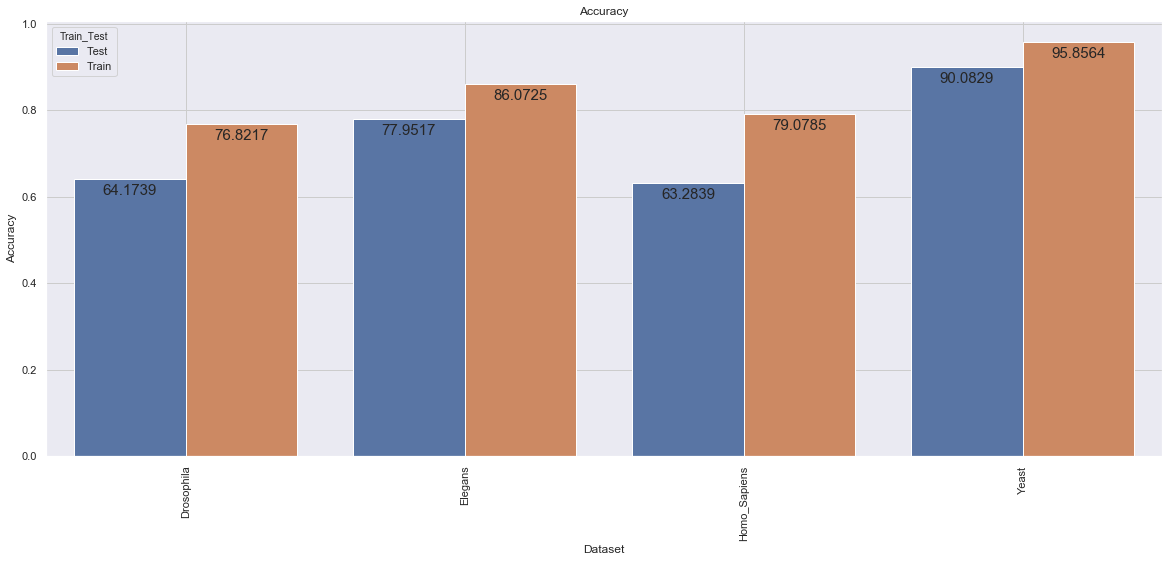

In [18]:
##################################################################################
##### Visualize with a multiple Bar chart
##################################################################################

# df = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(0), [dataset_to_print])]
# df = evaluations_df_grouped.reset_index(level=['Dataset', 'Encoding_Type', 'Train_Test'])
df = evaluations_df_grouped.reset_index()

# Some boilerplate to initialise things
sns.set()
plt.figure(figsize=(20,8))

# Draw the bars
ax = sns.barplot(data=df, x="Dataset", y=metric_to_plot, hue="Train_Test")

# Customise some display properties
ax.set_title(metric_to_plot)
ax.grid(color='#cccccc')
ax.set_ylabel(metric_to_plot)
ax.set_xlabel("Dataset")
ax.set_xticklabels(df["Dataset"].unique().astype(str), rotation='vertical')

for p in ax.patches:
    ax.annotate(format(p.get_height()*100, '.4f'),
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                size=15,
                xytext = (0, -12), 
                textcoords = 'offset points')

##############################

# Ask Matplotlib to show it
plt.show()

### Store all metrics' plots to file

In [19]:
##################################################################################
##### Iteratively generate comparison plot using every metric
##################################################################################

for metric_to_plot in list(evaluations_df_grouped.columns):
    
    # df = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(0), [dataset_to_print])]
    # df = evaluations_df_grouped.reset_index(level=['Dataset', 'Encoding_Type', 'Train_Test'])
    df = evaluations_df_grouped.reset_index()

    # Some boilerplate to initialise things
    sns.set()
    plt.figure(figsize=(20,8))

    # Draw the bars
    ax = sns.barplot(data=df, x="Dataset", y=metric_to_plot, hue="Train_Test")

    # Customise some display properties
    ax.set_title(metric_to_plot+" for Setting1")
    ax.grid(color='#cccccc')
    ax.set_ylabel(metric_to_plot)
    ax.set_xlabel("Dataset")
    ax.set_xticklabels(df["Dataset"].unique().astype(str), rotation='vertical')

    for p in ax.patches:
        ax.annotate(format(p.get_height()*100, '.4f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    size=15,
                    xytext = (0, -12), 
                    textcoords = 'offset points')

    plt.savefig(os.path.join(evalPath, "{}_{}_Comparison".format(metric_to_plot, modelNames[0])))
    plt.close()
    